# Inputs

@[Chaoming Wang](https://github.com/chaoming0625)
@[Xiaoyu Chen](mailto:c-xy17@tsinghua.org.cn)

In this section, we are going to talk about stimulus inputs.

In [1]:
import brainpy as bp
import brainpy.math as bm

## Inputs in ``brainpy.dyn.DSRunner``

In brain dynamics simulation, various inpus are usually given to different units of the dynamical system. In BrainPy, `inputs` can be specified to [runners for dynamical systems](runners.ipynb). The aim of ``inputs`` is to mimic the input operations in experiments like Transcranial Magnetic Stimulation (TMS) and patch clamp recording.

``inputs`` should have the format like ``(target, value, [type, operation])``, where 
- ``target`` is the target variable to inject the input.
- ``value`` is the input value. It can be a scalar, a tensor, or a iterable object/function.
- ``type`` is the type of the input value. It support two types of input: ``fix`` and ``iter``. The first one means that the data is static; the second one denotes the data can be iterable, no matter whether the input value is a tensor or a function. The `iter` type must be explicitly stated. 
- ``operation`` is the input operation on the target variable. It should be set as one of `{ + , - , * , / , = }`, and if users do not provide this item explicitly, it will be set to '+' by default, which means that the target variable will be updated as ``val = val + input``. 

Users can also give multiple inputs for different target variables, like:

```python

inputs=[(target1, value1, [type1, op1]),  
        (target2, value2, [type2, op2]),
              ... ]
```

The mechanism of ``inputs`` is the same as [``monitors``](monitors.ipynb). BrainPy finds the target variables for input operations through [the absolute or relative path](../tutorial_math/base.ipynb). 

## Input construction functions 

Like electrophysiological experiments, model simulation also needs various kind of inputs. BrainPy provide several convenient input functions to help users construct input currents. 

### 1\. ``brainpy.inputs.section_input()``

[brainpy.inputs.section_input()](../apis/inputs/generated/brainpy.inputs.section_input.rst) is an updated function of previous `brainpy.inputs.constant_input()` (see below).

Sometimes, we need input currents with different values in different periods. For example, if you want to get an input that is 0 in the first 100 ms, 1 in the next 300 ms, and 0 again from the last 100 ms, you can define:

In [2]:
current1, duration = bp.inputs.section_input(values=[0, 1., 0.],
                                             durations=[100, 300, 100],
                                             return_length=True,
                                             dt=0.1)

Where `values` receive a list/arrray of the current values in each section and `durations` receives a list/array of the duration of each section. The function returns a tensor as the current, the length of which is `duration`$/\mathrm{d}t$ (if not specified, $\mathrm{d}t=0.1 \mathrm{ms}$). We can visualize the current input by:

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def show(current, duration, title):
    ts = np.arange(0, duration, bm.get_dt())
    plt.plot(ts, current)
    plt.title(title)
    plt.xlabel('Time [ms]')
    plt.ylabel('Current Value')
    plt.show()

show(current1, duration, 'values=[0, 1, 0], durations=[100, 300, 100]')

### 2\. ``brainpy.inputs.constant_input()``

[brainpy.inputs.constant_input()](../apis/inputs/generated/brainpy.inputs.constant_input.rst) function helps users to format constant currents in several periods.

We can generate the above input current with `constant_input()` by:

In [4]:
current2, duration = bp.inputs.constant_input([(0, 100), (1, 300), (0, 100)])

Where each tuple in the list contains the value and duration of the input in this section.

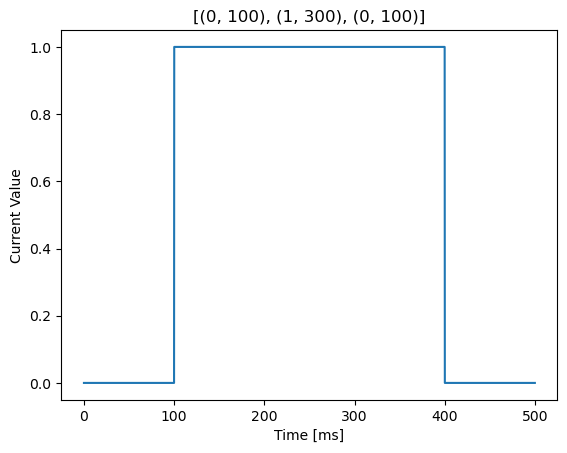

In [5]:
show(current2, duration, '[(0, 100), (1, 300), (0, 100)]')

### 3\. ``brainpy.inputs.spike_input()``

[brainpy.inputs.spike_input()](../apis/inputs/generated/brainpy.inputs.spike_input.rst) constructs an input containing a series of short-time spikes. It receives the following settings:

- `sp_times` :  The spike time-points. Must be an iterable object. For example, list, tuple, or arrays.
- `sp_lens` : The length of each point-current, mimicking the spike durations. It can be a scalar float to specify the unified duration. Or, it can be list/tuple/array of time lengths with the length same with `sp_times`. 
- `sp_sizes` : The current sizes. It can be a scalar value. Or, it can be a list/tuple/array of spike current sizes with the length same with `sp_times`.
- `duration` : The total current duration.
- `dt` : The time step precision. The default is None (will be initialized as the default `dt` step). 

For example, if you want to generate a spike train at 10 ms, 20 ms, 30 ms, 200 ms, 300 ms, where each spike lasts 1 ms and the average value for each spike is 0.5, then you can define the current by:

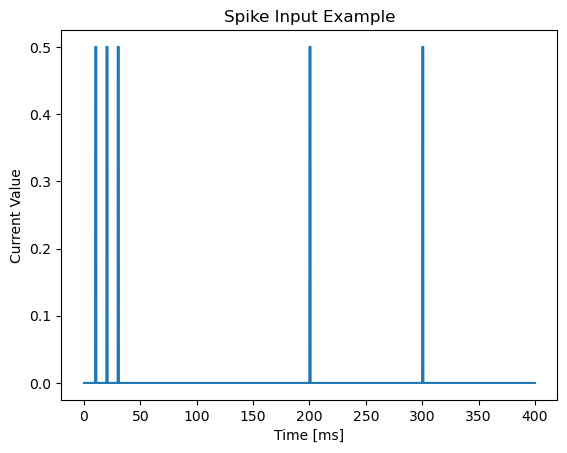

In [6]:
current3 = bp.inputs.spike_input(
    sp_times=[10, 20, 30, 200, 300],
    sp_lens=1.,  # can be a list to specify the spike length at each point
    sp_sizes=0.5,  # can be a list to specify the spike current size at each point
    duration=400.)

show(current3, 400, 'Spike Input Example')

### 4\. ``brainpy.inputs.ramp_input()``

[brainpy.inputs.ramp_input()](../apis/inputs/generated/brainpy.inputs.ramp_input.rst) mimics a ramp or a step current to the input of the circuit. It receives the following settings:

- `c_start` : The minimum (or maximum) current size.
- `c_end` : The maximum (or minimum) current size.
- `duration` : The total duration.
- `t_start` : The ramped current start time-point.
- `t_end` : The ramped current end time-point. Default is the None.
- `dt` : The current precision.

We illustrate the usage of `brainpy.inputs.ramp_input()` by two examples.

In the first example, we increase the current size from 0. to 1. between the start time (0 ms) and the end time (500 ms). 

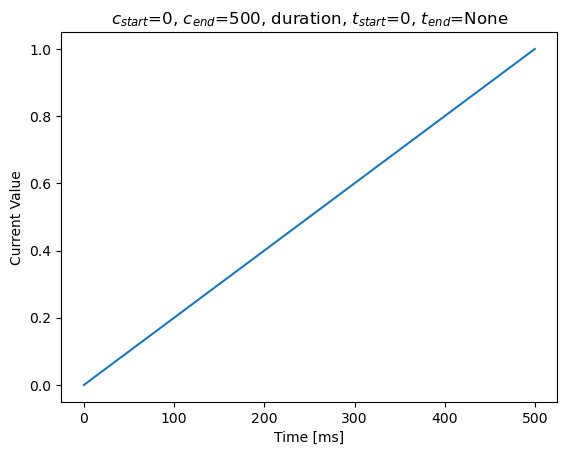

In [7]:
duration = 500
current4 = bp.inputs.ramp_input(0, 1, duration)

show(current4, duration, r'$c_{start}$=0, $c_{end}$=%d, duration, '
                        r'$t_{start}$=0, $t_{end}$=None' % (duration))

In the second example, we increase the current size from 0. to 1. from the 100 ms to 400 ms.

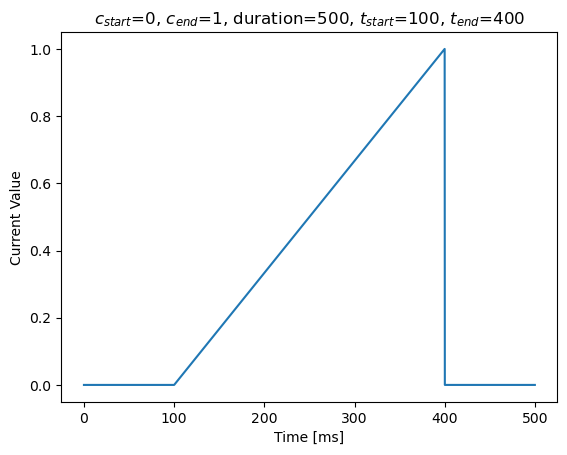

In [8]:
duration, t_start, t_end = 500, 100, 400
current5 = bp.inputs.ramp_input(0, 1, duration, t_start, t_end)

show(current5, duration, r'$c_{start}$=0, $c_{end}$=1, duration=%d, '
                        r'$t_{start}$=%d, $t_{end}$=%d' % (duration, t_start, t_end))

### 5\. ``brainpy.inputs.wiener_process``

[brainpy.inputs.wiener_process()](../apis/inputs/generated/brainpy.inputs.wiener_process.rst) is used to generate the basic Wiener process $dW$, i.e. random numbers drawn from $N(0, \sqrt{dt})$.

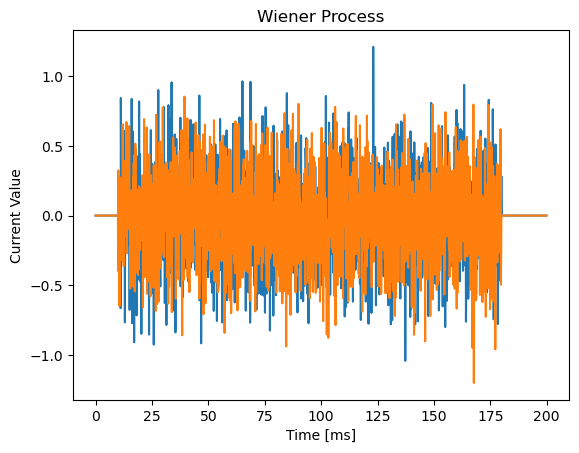

In [9]:
duration = 200
current6 = bp.inputs.wiener_process(duration, n=2, t_start=10., t_end=180.)
show(current6, duration, 'Wiener Process')

### ``brainpy.inputs.ou_process``

[brainpy.inputs.ou_process()](../apis/inputs/generated/brainpy.inputs.ou_process.rst) is used to generate the noise time series from Ornstein-Uhlenback process $\dot{x} = (\mu - x)/\tau \cdot dt + \sigma\cdot dW$.

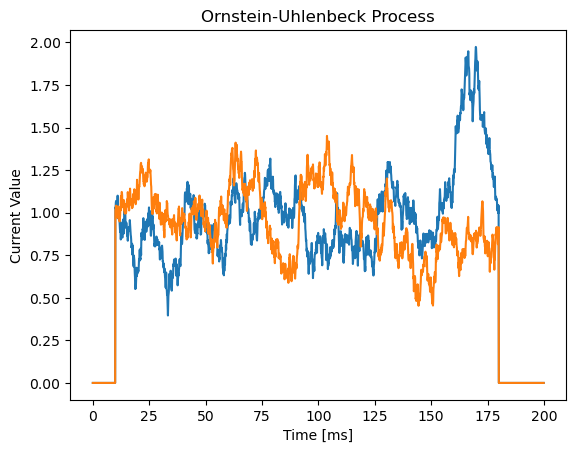

In [10]:
duration = 200
current7 = bp.inputs.ou_process(mean=1., sigma=0.1, tau=10., duration=duration, n=2, t_start=10., t_end=180.)
show(current7, duration, 'Ornstein-Uhlenbeck Process')

### ``brainpy.inputs.sinusoidal_input``

[brainpy.inputs.sinusoidal_input()](../apis/inputs/generated/brainpy.inputs.sinusoidal_input.rst) can help to generate sinusoidal inputs.

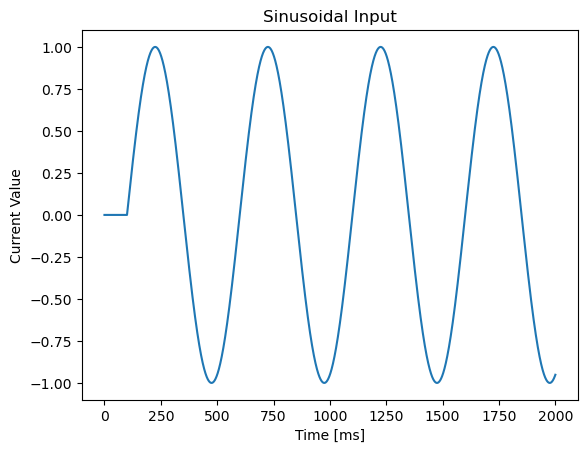

In [11]:
duration = 2000
current8 = bp.inputs.sinusoidal_input(amplitude=1., frequency=2.0, duration=duration,  t_start=100., )
show(current8, duration, 'Sinusoidal Input')

### ``brainpy.inputs.square_input``

[brainpy.inputs.square_input()](../apis/inputs/generated/brainpy.inputs.square_input.rst) can help to generate oscillatory square inputs.

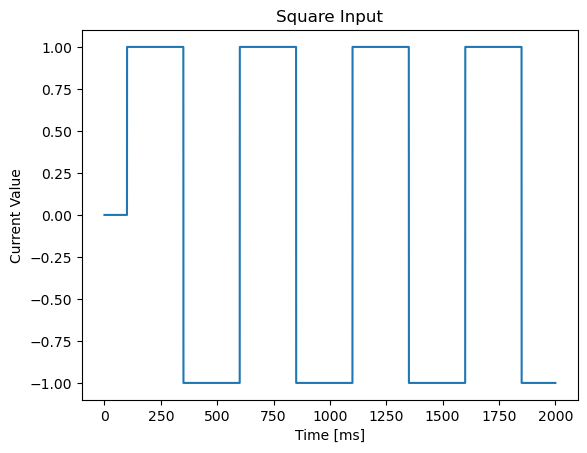

In [12]:
duration = 2000
current9 = bp.inputs.square_input(amplitude=1., frequency=2.0,
                                  duration=duration, t_start=100)
show(current9, duration, 'Square Input')

### More complex inputs

Because the current input is stored as a tensor, a complex input can be realized by the combination of several simple currents.

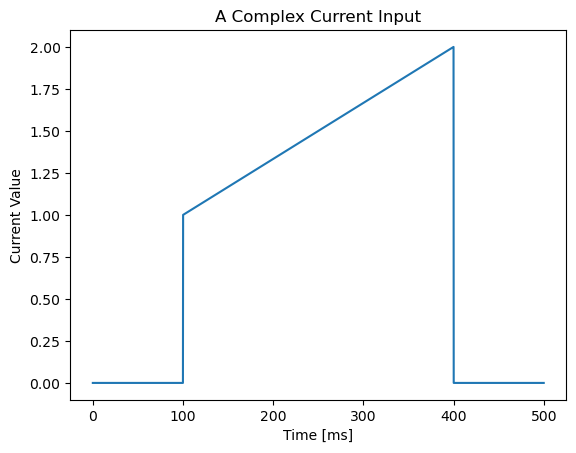

In [13]:
show(current1 + current5, 500, 'A Complex Current Input')

## General properties of input functions

**1\. Every input function receives a ``dt`` specification.**

If ``dt`` is not provided, input functions will use the default ``dt`` in the whole BrainPy system. 

In [14]:
I1 = bp.inputs.section_input(values=[0, 1, 2], durations=[10, 20, 30], dt=0.1)
I2 = bp.inputs.section_input(values=[0, 1, 2], durations=[10, 20, 30], dt=0.01)
print('I1.shape: {}'.format(I1.shape))
print('I2.shape: {}'.format(I2.shape))

I1.shape: (600,)
I2.shape: (6000,)


**2\. All input functions can automatically broadcast the current shapes if they are heterogenous among different periods.**

For example, during period 1 we give an input with a scalar value, during period 2 we give an input with a vector shape, and during period 3 we give a matrix input value. Input functions will broadcast them to the maximum shape. For example:

In [15]:
current = bp.inputs.section_input(values=[0, bm.ones(10), bm.random.random((3, 10))],
                                  durations=[100, 300, 100])

current.shape

(5000, 3, 10)